In [1]:
!pip install keras-video-generators

  Created wheel for keras-video-generators: filename=keras_video_generators-1.0.13-cp36-none-any.whl size=12729 sha256=5f4fec975c2c2d008bf3f519cce88f41e1548c74568d297db901b71b0f6690bf
  Stored in directory: /root/.cache/pip/wheels/f4/9a/15/fa18c9caaeb672d7deb2b5be938fcf0c29b259c0cf40aa43f7
Successfully built keras-video-generators


In [3]:
import os
import glob
import keras
from keras_video import VideoFrameGenerator

# use sub directories names as classes
#classes = [i.split(os.path.sep)[1] for i in glob.glob('/content/drive/My Drive/DLProj/Sub2/Dataset/*')]
#classes.sort()
classes = ['Door' , 'Not_Door']
# some global params
SIZE = (300, 300)
CHANNELS = 3
NBFRAME = 15
BS = 10
# pattern to get videos and classes
glob_pattern='/content/drive/My Drive/DL Proj/Sub2/Dataset/{classname}/*.mp4'
# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)
# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split_val=.25,  # 33% of the videos will be used as validation set. 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=False)

class Door, validation count: 43, train count: 131
class Not_Door, validation count: 43, train count: 132
Total data: 2 classes for 263 files for train


In [4]:
valid = train.get_validation_generator()

Total data: 2 classes for 86 files for validation


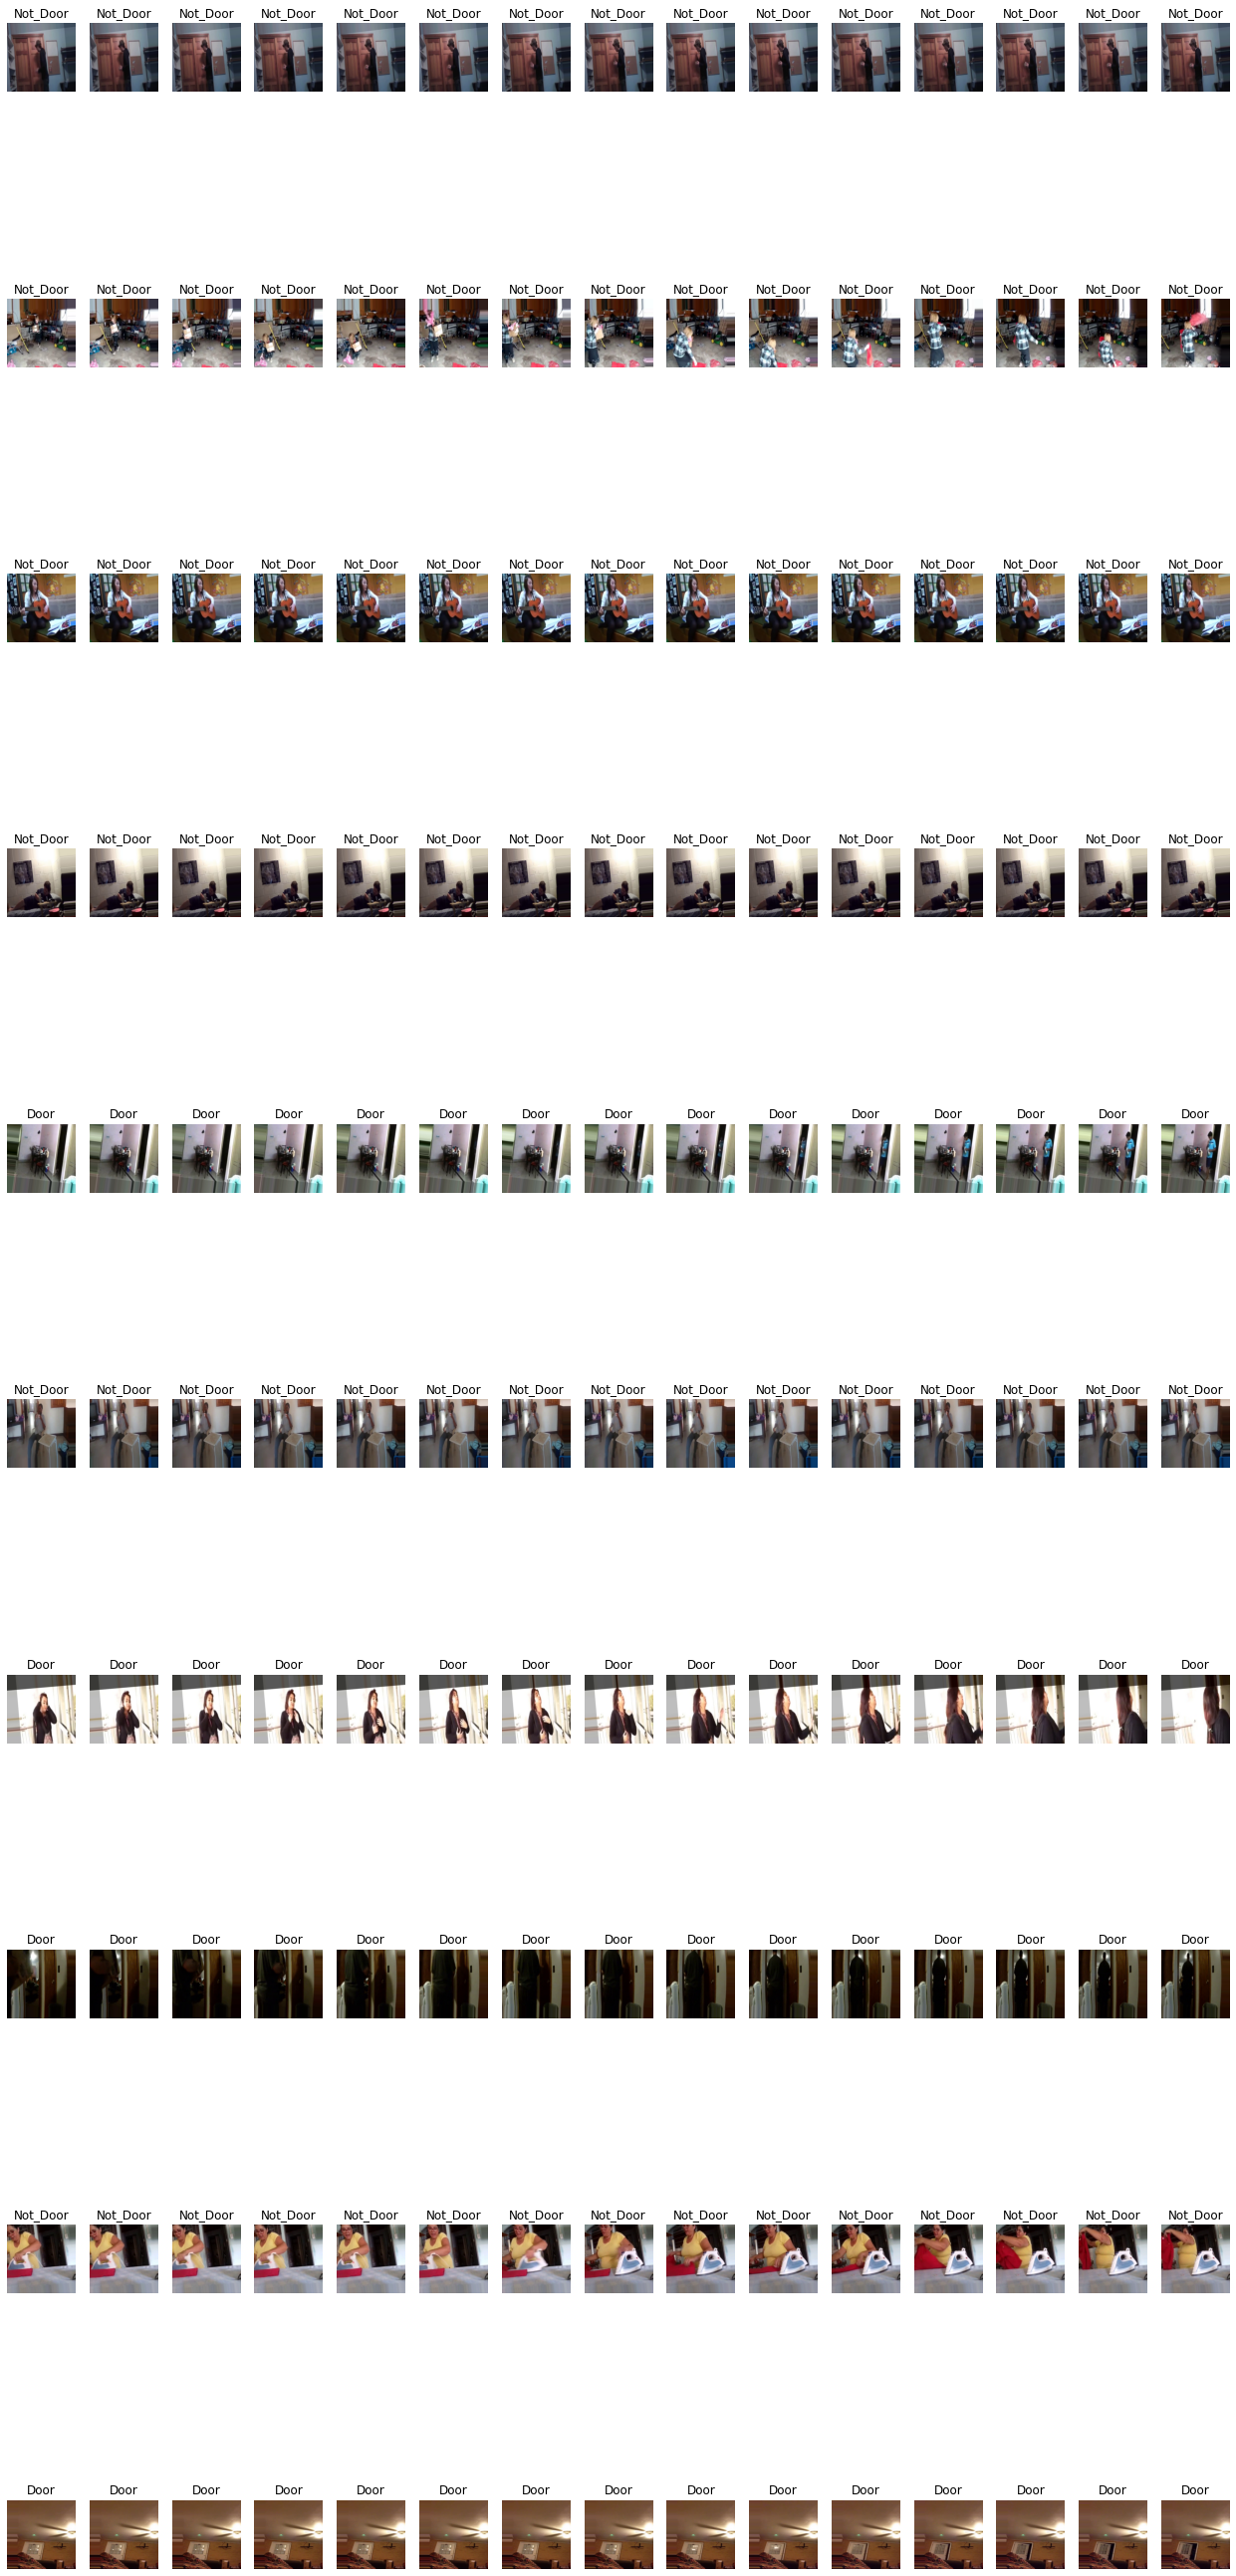

In [5]:
import keras_video.utils
keras_video.utils.show_sample(train)

In [0]:
from tensorflow.keras import backend
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import (Conv2D, MaxPooling3D, Conv3D,MaxPooling2D)
from tensorflow.keras.layers import Dense, Flatten, Dropout, ZeroPadding3D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam, RMSprop
from collections import deque
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten

In [0]:
def conv_block(model, kernel_filters, init, reg_lambda):
    # conv
    model.add(TimeDistributed(Conv2D(kernel_filters, (3, 3), padding='same',
                            kernel_initializer=init, kernel_regularizer=l2(l=reg_lambda))))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Activation('relu')))
    # conv
    model.add(TimeDistributed(Conv2D(kernel_filters, (3, 3), #padding='same',
                            kernel_initializer=init, kernel_regularizer=l2(l=reg_lambda))))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Activation('relu')))
    # max pool
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    return model

In [9]:
initialiser = 'glorot_uniform'
reg_lambda  = 0.001

model = Sequential()
# first (non-default) block
model.add(TimeDistributed(Conv2D(32, (7, 7), strides=(3, 3), #padding='same',
                                    kernel_initializer=initialiser, kernel_regularizer=l2(l=reg_lambda),
                                     activation = 'relu'
                                    ),
                                    input_shape=(15, 300, 300, 3)
                                     ))
model.add(TimeDistributed(Conv2D(32, (3,3), 
                                 kernel_initializer=initialiser, 
                                 kernel_regularizer=l2(l=reg_lambda)))
                                 )
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# 2nd-5th (default) blocks
model = conv_block(model, 64,  init=initialiser, reg_lambda=reg_lambda)
model = conv_block(model, 128, init=initialiser, reg_lambda=reg_lambda)
model.add(TimeDistributed(BatchNormalization()))
model = conv_block(model, 256, init=initialiser, reg_lambda=reg_lambda)

# LSTM output head
model.add(TimeDistributed(Flatten()))
model.add(LSTM(128, return_sequences=False, dropout=0.5))
model.add(Dense(128, activation= 'relu'))
model.add(Dense(64, activation= 'relu'))
model.add(Dense(2, activation='softmax'))

#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
model.summary()

#model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=metrics)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 15, 98, 98, 32)    4736      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 96, 96, 32)    9248      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 15, 96, 96, 32)    128       
_________________________________________________________________
time_distributed_8 (TimeDist (None, 15, 96, 96, 32)    0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 15, 48, 48, 32)    0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, 15, 48, 48, 64)    18496     
_________________________________________________________________
time_distributed_11 (TimeDis (None, 15, 48, 48, 64)   

In [0]:
#optimizer = Adam(lr=1e-5, decay=1e-6)
optimizer= RMSprop(lr=1e-4)
model.compile(optimizer=optimizer , 
              loss='categorical_crossentropy',
              #loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger
import os.path
import time

early_stopper = EarlyStopping(patience=5)
#tb = TensorBoard(log_dir=os.path.join('F:\DLProj\ver4', 'logs'))
timestamp = time.time()
csv_logger =  CSVLogger(os.path.join('/content/drive/My Drive/DL Proj/Sub2_1/logs', 'logs' + '-' + 'training-' + \
                        str(timestamp) + '.log'))

# Create a TensorBoard logger
tb = TensorBoard(
    log_dir='logs',
    write_graph=True,
    histogram_freq=5)

checkpoint = ModelCheckpoint('/content/drive/My Drive/DL Proj/Sub2_1/models/model_saved.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_acc', verbose=1) #save_best_only=True, mode='max', period=1)


In [12]:
history = model.fit_generator(
                    train, 
                    validation_data= valid, 
                    steps_per_epoch = 26,
                    validation_steps = 10,
                    #batch_size= 10,
                    verbose=1,
                    callbacks=[ csv_logger, checkpoint ],
                    #keras.callbacks.ModelCheckpoint('/content/drive/My Drive/DL Proj/Sub2/model_saved.{epoch:02d}-{val_loss:.2f}.hdf5',verbose=1),  ],
                    epochs = 100)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 1.4925 - accuracy: 0.4769 
Epoch 00001: saving model to /content/drive/My Drive/DL Proj/Sub2_1/models/model_saved.01-1.48.hdf5
26/26 [==============================] - 376s 14s/step - loss: 1.4925 - accuracy: 0.4769 - val_loss: 1.4776 - val_accuracy: 0.4500
Epoch 2/100
26/26 [==============================] - ETA: 0s - loss: 1.4704 - accuracy: 0.5538
Epoch 00002: saving model to /content/drive/My Drive/DL Proj/Sub2_1/models/model_saved.02-1.48.hdf5
26/26 [==============================] - 68s 3s/step - loss: 1.4704 - accuracy: 0.5538 - val_loss: 1.4781 - val_accuracy: 0.5300
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 1.4648 - accuracy: 0.5154
Epoch 00003: saving model to /content/drive/My Drive/DL Proj/Sub2_1/models/model_saved.03-1.50.hdf5
26/26 [==============================] - 62s 2s/step - loss: 1.4648 - accuracy

In [1]:
import matplotlib.pyplot as plt
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
xc=range(100)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
print (plt.style.available) # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

NameError: ignored